
Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 6 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [ ]:
# Скачаем архив с симптомами болезней
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l8/diseases.zip', None, quiet=True)

'diseases.zip'

In [ ]:
# Распакум архив
!unzip -o diseases.zip

Archive:  diseases.zip
   creating: dis/
  inflating: dis/Аппендицит.txt  
  inflating: dis/Гастрит.txt  
  inflating: dis/Гепатит.txt  
  inflating: dis/Дуоденит.txt  
  inflating: dis/Колит.txt      
  inflating: dis/Панкреатит.txt  
  inflating: dis/Холицестит.txt  
  inflating: dis/Эзофагит.txt  
  inflating: dis/Энтерит.txt  
  inflating: dis/Язва.txt        


In [ ]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [ ]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла

    if ext=='txt':                                         # Если расширение txt то берем файл в работу
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"


In [ ]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST)

In [ ]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [ ]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Гастрит
  train: ГАСТРИТ СИМПТОМЫ  диспепсии (тяжесть и чувство давления, полноты в подложечной области, отрыжка, срыгивание, тошнота, неприятный привкус во рту, жжение в эпигастрии, изжога ) ноющая или острая жгучая боль в верхней части живота; ощущение переполненности в верхней части живота после еды; слабость, раздражительность; рвота; отсутствие аппетита; метеоризм; отрыжка; потеря веса; язык обложен грязно-желтым или серовато-белым налетом; головокружение; нарушения со стороны сердечно-сосудистой системы — кардиалгия, аритмия, артериальная неустойчивость; у пациентов с атрофическим хроническим гастритом может развиться симптомокомплекс: внезапная слабость, бледность, потливость, сонливость, в случаях инфекционного гастрита возможно появление лихорадки;  боль в животе: резкая приступообразная или постоянная мучительная; отрыжка с кислым запахом; многократная рвота ( возможна рвота с кровью);повышенное слюноотделение; иногда сухость во рту; нарушение стула: запор или понос; с

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [ ]:
#ваше решение
# Функция для создания и обучения токенайзера.

def make_tokenizer(VOCAB_SIZE, #Размер словаря
                   text_train  #Обучающая выборка
                   ):

    tokenizer = Tokenizer(num_words=VOCAB_SIZE,                                           # Создаем токенайзер с размером словаря VOCAB_SIZE.
                          filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',  # Знаки препинания, скобки, спец символы убираем
                          lower=True,                                                     # Все символы переводим в прописные
                          split=' ',                                                      # Слова разделяются пробелом
                          oov_token='неизвестное_слово',                                  # Слова не вошедшие в словарь помечаем как 'неизвестное_слово'
                          char_level=False)                                               # Запрещаем токенизировать каждый символ

    # Обучим токенайзер
    tokenizer.fit_on_texts(text_train)

    # Вернем обученный токенайзер
    return tokenizer

In [ ]:
# Функция для перевода текста в токены (индексы)

def make_train_test(tokenizer,       # Предобученный токенайзер
                    text_train,      # Обучающая выборка
                    text_test = None # Тестовая выборка
                    ):

    # Переведем обучающую выборку из слов в токены
    seq_train = tokenizer.texts_to_sequences(text_train)

    if text_test:
        # Переведем тестовую выборку в токены
        seq_test = tokenizer.texts_to_sequences(text_test)
    else:
       # Тестовой выборки нет - отдадим None
        seq_test = None

    # Вернем  обучающий и тестовый датасеты в виде токенов
    return seq_train, seq_test

In [ ]:
# Функция вывода статистики по текстам

def print_text_stats(title,                  # Заголовок для блока статистики
                     texts,                  # Тексты в виде слов
                     sequences,              # Тексты в виде индексов
                     class_labels=CLASS_LIST # Список классов
                     ):

    chars = 0
    words = 0

    # Выведем заголовок
    print(f'Статистика по {title} текстам:')

    # Выведем итоги по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],      # Выводим количество имя класса, символом, слов
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])                                              # Готовим сумму всех символов
        words += len(sequences[cls])                                          # Готовим сумму всех слов

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words)) # Выведем статистику по всему датасету


In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна

def split_sequence(sequence,  # Тексты в виде индексов
                   win_size,  # Размер окна
                   hop        # Шаг смещения окна
                   ):

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

In [ ]:
# Функция формирования выборок из последовательностей индексов

def vectorize_sequence(seq_list, #  Список категорий текстов
                       win_size, # Размер окна
                       hop       # Шаг смещения окна
                       ):

    # Найдем количество классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разобъем последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавим отрезки в выборку
        x += vectors

        # Для всех отрезков класса cls добавим меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Вернем как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
# Функция компиляции и обучения модели нейронной сети

def compile_train_model(model,            # Необученная модель
                        x_train,          # Обучающая выборка текста
                        y_train,          # Обучающая выборка меток классов
                        x_val,            # Проверочная выборка текста
                        y_val,            # Проверочная выборка меток классов
                        optimizer='adam', # Используемый оптимайзер
                        epochs=50,        # Количество эпох обучения
                        batch_size=128,   # Размер батча
                        figsize=(20, 5)): # Размер графиков для отображения результата

    # Компилируем модель
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Выводим сводки
    model.summary()

    # Выводим схему модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучаем модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Выведем графики точности и ошибки

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)            # Создадим набор графиков
    fig.suptitle('График процесса обучения модели')                  # Добавим заголовок
    ax1.plot(history.history['accuracy'],                            # Добавим график точности распознавания на первый рисунок
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],                        # Добавим график точности распознавания на тестовый данных на первый рисунок
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')                                 # Добавим подпись на горизонтальную ось
    ax1.set_ylabel('Доля верных ответов')                            # Добавим подпись на вертикальную ось
    ax1.legend()                                                     # Добавим легенду на рисунок

    ax2.plot(history.history['loss'],                                # Добавим график потерь на второй рисунок
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],                            # Добавим график потерь на тестовый данных   на второй рисунок
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')                                 # Добавим подпись на горизонтальную ось
    ax2.set_ylabel('Ошибка')                                         # Добавим подпись на вертикальную ось
    ax2.legend()                                                     # Добавим легенду на рисунок
    plt.show()                                                       # Отрисуем набор графиков

    # Вернем обученную модель
    return model

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,             # Обученная модель
               x,                 # Тестовая выборка текста
               y_true,            # Тестовая выборка меток классов
               class_labels=[],   # Названия классов
               cm_round=2,        # Параметр округления результатов
               title='',          # Общий заголовок
               figsize=(25, 25)): # Размер графиков

    # Вычислим предсказание сети
    y_pred = model.predict(x)

    # Считаем матрицу ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок

    fig, ax = plt.subplots(figsize=figsize)                                          # Создадим шаблон для набора графиков
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)  # Добавим заголовок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)  # Подготовим матрицу ошибок к отрисовке
    disp.plot(ax=ax)                                                                 # Отрисуем матрицу
    plt.gca().images[-1].colorbar.remove()                                           # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=26)                                  # Зададим название горизонтальной оси
    plt.ylabel('Верные классы', fontsize=26)                                         # Зададим название вертикальной оси
    fig.autofmt_xdate(rotation=45)                                                   # Наклон меток горизонтальной оси при необходимости
    plt.show()                                                                       # Отрисуем набор графиков

    print('-'*100)
    print(f'Нейросеть: {title}')                                                     # Выведем название сети

    # Для каждого класса:

    for cls in range(len(class_labels)):

        # Определяем индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])

        # Формируем сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('

        # Выводим текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                   # Необученная модель
                             x_train,                 # Обучающая выборка текста
                             y_train,                 # Обучающая выборка меток классов
                             x_test,                  # Тестовая выборка текста
                             y_test,                  # Тестовая выборка меток классов
                             class_labels=CLASS_LIST, # Список названий классов
                             title='',                # Общий заголовок
                             optimizer='adam',        # Используемый оптимайзер
                             epochs=50,               # Количество эпох
                             batch_size=128,          # Размер батча
                             graph_size=(20, 5),      # Размер графиков результатов обучения
                             cm_size=(15, 15)         # Размер графиков результатов проверки
                             ):

    # Скомпилируем и обучим модель на заданных параметрах
    # В качестве проверочных используем тестовые данные
    model = compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Выведем результаты оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)
    return model

In [ ]:
# Функция для сборки модели

def make_mod(VOCAB_SIZE, # Размер словаря
             WIN_SIZE,   # Размер данных
             CLASS_COUNT # Количество классов текстов
             ):

    model = Sequential()                                        # Создадим модель
    model.add(Embedding(VOCAB_SIZE, 10, input_length=WIN_SIZE)) # Добавим эмбеддинг
    model.add(SpatialDropout1D(0.2))                            # Добавим дропаут для целых векторов в эмбеддинг пространстве
    model.add(BatchNormalization())                             # Добавим нормализацию по батчу
    model.add(Conv1D(20, 3, activation='relu'))                 # Добавим слой одномерной свертки Conv1D
    model.add(Conv1D(20, 3, activation='relu'))                 # Добавим слой одномерной свертки Conv1D
    model.add(MaxPooling1D(2))                                  # Добавим слой подвыборки/пулинга с функцией максимума
    model.add(Dropout(0.2))                                     # Добавим простой дропаут  с долей отключаемых нейронов 0.2
    model.add(BatchNormalization())                             # Добавим нормализацию по батчу
    model.add(Flatten())                                        # Перегоним выход предыдущего слоя в одномерный массив
    model.add(Dense(100, activation='relu'))                    # Добавим dense слой с числом нейронов =100
    model.add(Dense(CLASS_COUNT, activation='softmax'))         # Добавим выходной dense слой с числом нейронов равным числу распознаваемых классов

    # Вернем модель
    return model

In [ ]:
# Задание параметров преобразования

VOCAB_SIZE = 1800                       # Объем словаря для токенизатора
WIN_SIZE   = 50                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 1                          # Шаг окна разбиения текста на векторы

In [ ]:
# Формирование обучающей и тестовой выборок

with timex():

    # Получим обученный токенайзер
    tok = make_tokenizer(VOCAB_SIZE, text_train) # Получим обученный токенайзер

    # Переверем выборки из слов в токены
    seq_train, seq_test = make_train_test(tok, text_train, text_test)

    # Выведем фрагмент обучающего текста
    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[0][:101])
    print("Он же в виде последовательности индексов: ", seq_train[0][:20])

    # Формируем обучающую выборку
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)

    # Формируем тестовую выборку
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

Фрагмент обучающего текста:
В виде оригинального текста:               ГАСТРИТ СИМПТОМЫ  диспепсии (тяжесть и чувство давления, полноты в подложечной области, отрыжка, срыг
Он же в виде последовательности индексов:  [737, 108, 257, 66, 3, 44, 87, 738, 2, 123, 14, 15, 258, 6, 55, 95, 18, 27, 141, 2]
Время обработки: 0.06 с


In [ ]:
# Выведем итоги формирования выборок

print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)

Статистика по обучающим текстам:
Гастрит              5440 символов,     660 слов
Гепатит              4385 символов,     555 слов
Панкреатит           9217 символов,    1183 слов
Дуоденит             3186 символов,     393 слов
Холицестит           4951 символов,     675 слов
Эзофагит             4647 символов,     639 слов
Колит                7262 символов,     950 слов
Аппендицит           3257 символов,     471 слов
Язва                 2728 символов,     376 слов
Энтерит              5151 символов,     662 слов
----
В сумме             50224 символов,    6564 слов

Статистика по тестовым текстам:
Гастрит              1276 символов,     179 слов
Гепатит              1137 символов,     132 слов
Панкреатит           2095 символов,     297 слов
Дуоденит              754 символов,      95 слов
Холицестит           1205 символов,     166 слов
Эзофагит             1219 символов,     154 слов
Колит                1864 символов,     242 слов
Аппендицит            817 символов,     108 сло

In [ ]:
# Проверим размерности сформированных данных

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6074, 50) (6074, 10)
(1145, 50) (1145, 10)


In [ ]:
# Получим модель
model_Conv_1 = make_mod(VOCAB_SIZE,WIN_SIZE,CLASS_COUNT)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 10)            18000     
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 10)            0         
 Dropout1D)                                                      
                                                                 
 batch_normalization (Batch  (None, 50, 10)            40        
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 48, 20)            620       
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 20)            1220      
                                                                 
 max_pooling1d (MaxPooling1  (None, 23, 20)            0

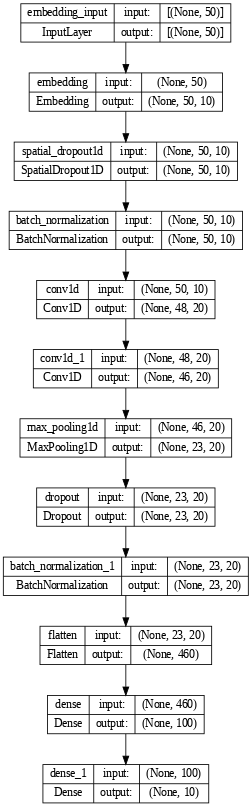

Epoch 1/100
61/61 [==============================] - 17s 164ms/step - loss: 2.3888 - accuracy: 0.1864 - val_loss: 2.2278 - val_accuracy: 0.2166
Epoch 2/100
61/61 [==============================] - 6s 97ms/step - loss: 0.8941 - accuracy: 0.7112 - val_loss: 2.6493 - val_accuracy: 0.1135
Epoch 3/100
61/61 [==============================] - 4s 56ms/step - loss: 0.2111 - accuracy: 0.9519 - val_loss: 3.4645 - val_accuracy: 0.1135
Epoch 4/100
61/61 [==============================] - 3s 44ms/step - loss: 0.0793 - accuracy: 0.9832 - val_loss: 3.9109 - val_accuracy: 0.1135
Epoch 5/100
61/61 [==============================] - 2s 33ms/step - loss: 0.0454 - accuracy: 0.9901 - val_loss: 3.9277 - val_accuracy: 0.1415
Epoch 6/100
61/61 [==============================] - 2s 30ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 3.7827 - val_accuracy: 0.2017
Epoch 7/100
61/61 [==============================] - 1s 20ms/step - loss: 0.0205 - accuracy: 0.9951 - val_loss: 3.2933 - val_accuracy: 0.2253
Epoc

In [ ]:
# Получим обученую модель, оценку ее работы
compile_train_eval_model(model_Conv_1,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='adam',
                         epochs=100,
                         batch_size=100,
                         class_labels=CLASS_LIST,
                         title='Язвы и прочие....')